In [87]:
import os
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')


# Loading images and masks paths

In [76]:
im_width=256
im_height=256

img_filenames_train=[]
mask_files=glob('../lgg-mri-segmentation/kaggle_3m/*/*_mask*')


for i in mask_files:
    
    img_filenames_train.append(i.replace('_mask',''))
    
print(img_filenames_train[:10])



['../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', '../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', '../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', '../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', '../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', '../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', '../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', '../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', '../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', '../lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']


# Plotting images

In [77]:
def plot_images(rows,columns,list_img_path,list_mask_path):
    
    fig=plt.figure(figsize=(12,12))
    
    for i in range(1,rows*columns+1):
        
        fig.add_subplot(rows,columns,i)
        img_path=list_img_path[i]
        mask_path=list_mask_path[i]
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        mask=cv2.imread(mask_path)
        
        plt.imshow(image)
        
        plt.imshow(mask,alpha=0.4)
    plt.show()

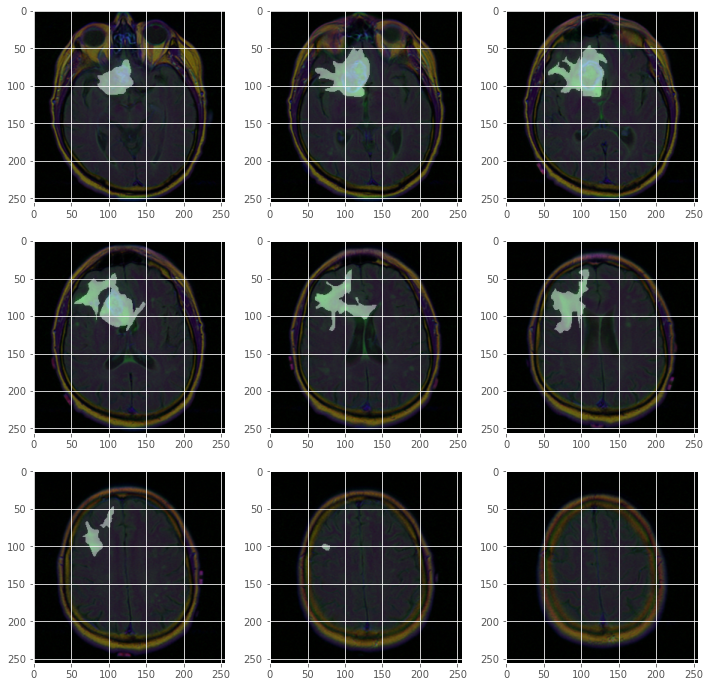

In [78]:
plot_images(3,3,img_filenames_train,mask_files)

In [79]:
def get_diagnosis(img_path):
    
    value=np.max(cv2.imread(img_path))
    
    if value>0:
        return 1
    else:
        return 0

In [80]:
df=pd.DataFrame(data={"image_filenames_train":img_filenames_train,'mask':mask_files})

df['target']=df['mask'].apply(lambda x:get_diagnosis(x))

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   image_filenames_train  3929 non-null   object
 1   mask                   3929 non-null   object
 2   target                 3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


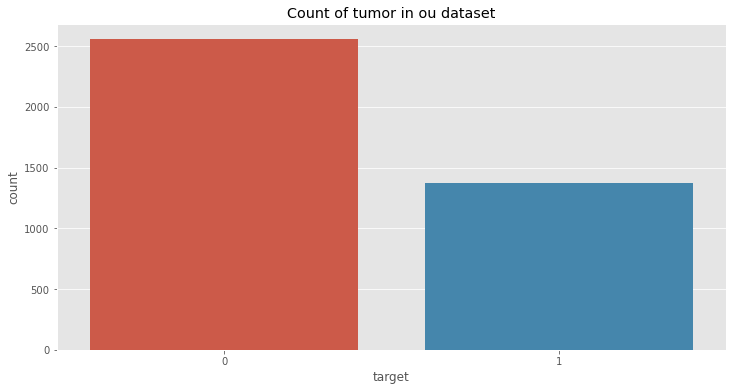

In [82]:
plt.figure(figsize=(12,6))

sns.countplot(df['target'])
plt.title('Count of tumor in ou dataset')

plt.show()

# Spliting data


In [83]:

df_train,df_test=train_test_split(df,test_size=0.1)

df_train,df_val=train_test_split(df_train,test_size=0.2)

print("shapes of train data {}".format(df_train.shape))
print("shapes of test data {}".format(df_test.shape))
print("shapes of train data {}".format(df_test.shape))

shapes of train data (2828, 3)
shapes of test data (393, 3)
shapes of train data (393, 3)


# Data Generator, data augmentation

In [84]:
#reference of this code : https://github.com/zhixuhao/unet/blob/master/data.py

def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [85]:
def normalize_and_diagnose(img,mask):
    
    img=img/255
    mask=mask/255
    
    mask[mask>0.5]==1
    mask[mask<=0.5]=0
    
    return (img,mask)

# Definning losses

In [97]:
def dice_coeff(y_true,y_pred,smooth=100):
    
    y_true_flatten=K.flatten(y_true)
    
    y_pred_flatten=K.flatten(y_pred)
    
    intersection=K.sum(y_true_flatten*y_pred_flatten)
    
    union=K.sum(y_true_flatten)+K.sum(y_pred_flatten)
    
    return (2*intersection*smooth)/(union*smooth)

def dice_coeff_loss(y_true,y_pred,smooth=100):
    
    return -dice_coeff(y_true,y_pred,smooth)

def iou(y_true,y_pred,smooth=100):
    
    intesection=K.sum(y_true*y_pred)
    sum=K.sum(y_true+y_pred)
    
    iou=(intesection+smooth)/(sum-intesection+smooth)
    
    return iou

def jacard_distance(y_true,y_pred):
    
    y_true_flatten=K.flatten(y_true)
    y_pred_flatten=K.flatten(y_pred)
    return -iou(y_true_flatten,y_pred_flatten)
    

# Building U-net from scratch 

In [73]:
def unet(input_size=(256,256,3)):
    
    inputs=Input(input_size)
    
    # Encoding leg
    
    conv1=Conv2D(filters=64,kernel_size=(3,3),padding='same')(inputs)
    
    bn1=Activation('relu')(conv1)
    
    conv1=Conv2D(filters=64,kernel_size=(3,3),padding='same')(bn1)
    bn1=Activation('relu')(conv1)
    bn1=Activation('relu')(bn1)
    pool1=MaxPooling2D(pool_size=(2,2))(bn1)
    
    
    conv2=Conv2D(filters=128,kernel_size=(3,3),padding='same')(pool1)
    bn2=Activation('relu')(conv2)
    conv2=Conv2D(filters=128,kernel_size=(3,3),padding='same')(bn2)
    bn2=Activation('relu')(conv2)
    bn1=Activation('relu')(bn2)
    pool2=MaxPooling2D(pool_size=(2,2))(bn2)
    
    
    
    conv3=Conv2D(filters=256,kernel_size=(3,3),padding='same')(pool2)
    bn3=Activation('relu')(conv3)
    conv3=Conv2D(filters=256,kernel_size=(3,3),padding='same')(bn3)
    bn3=BatchNormalization(axis=3)(conv3)
    bn3=Activation('relu')(bn3)
    pool3=MaxPooling2D(pool_size=(2,2))(bn3)
    
    
    conv3=Conv2D(filters=256,kernel_size=(3,3),padding='same')(pool2)
    bn3=Activation('relu')(conv3)
    conv3=Conv2D(filters=128,kernel_size=(3,3),padding='same')(bn3)
    bn3=BatchNormalization(axis=3)(conv3)
    bn3=Activation('relu')(bn3)
    pool3=MaxPooling2D(pool_size=(2,2))(bn3)
    
    
    conv4=Conv2D(filters=512,kernel_size=(3,3),padding='same')(pool3)
    bn4=Activation('relu')(conv4)
    conv4=Conv2D(filters=512,kernel_size=(3,3),padding='same')(bn4)
    bn4=BatchNormalization(axis=3)(conv4)
    bn4=Activation('relu')(bn4)
    pool4=MaxPooling2D(pool_size=(2,2))(bn4)
    
    
    conv5= Conv2D(filters=1024,kernel_size=(3,3),padding=('same'))(pool4)
    bn5=Activation('relu')(conv5)
    conv5=Conv2D(filters=1024,kernel_size=(3,3),padding=('same'))(bn5)
    bn5=BatchNormalization(axis=3)(conv5)
    bn5=Activation('relu')(bn5)
    
    # Part of upConvolution / Decoder part
    
    
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)
    
    return Model(inputs=[inputs],outputs=[conv10])
    
    
    
    
    
    
    
    
    
    

In [99]:
EPOCHS=50
BATCH_SIZE=16
learning_rate=1e-4
smooth=100

In [ ]:
train_generator_param=dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

train_gen=train_generator(df_train,BATCH_SIZE,train_generator_param,target_size=(im_height,im_width))

test_gen=train_generator(df_test,BATCH_SIZE,dict(),target_size=(im_height,im_width))

model=unet(input_size=(im_height,im_width,3))
decay_rate=learning_rate/EPOCHS

log_dir = './logs'

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model_checkpoint_callback = ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)

# combine both callbacks into a list
callbacks = [model_checkpoint_callback, tensorboard_callback]
optimizer=Adam(lr=learning_rate,decay=decay_rate)
# compile the model
model.compile(optimizer=optimizer, loss=dice_coeff_loss, metrics=['binary_accuracy', iou, dice_coeff])

# train the model with callbacks
history = model.fit(train_gen, steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=EPOCHS, callbacks=callbacks,
                    validation_data=test_gen, validation_steps=len(df_test)//BATCH_SIZE)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/50
 33/176 [====>.........................] - ETA: 1:38:09 - loss: -0.0678 - binary_accuracy: 0.8040 - iou: 0.0357 - dice_coeff: 0.0678